# Experimentación paper 7 Clustering y clasificación

## Librerías

In [25]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, time, joblib
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import yfinance as yf
from ripser import ripser
from persim import PersistenceImager, plot_diagrams
import pywt
import umap
import collections
collections.Iterable = collections.abc.Iterable
from sklearn.metrics import ConfusionMatrixDisplay

from statsmodels.tsa.stattools import acf
np.random.seed(42)


## Datos

In [ ]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN"] 

'''
df = yf.download(tickers, start="2018-01-01", end="2023-12-31", progress=False)
close = df['Close'].dropna(how='all')
close.plot(subplots=True, figsize=(10,6)); plt.suptitle("Cierre")

#guardamos df en un csv
close.to_csv("stocks_experimento_2.csv")
'''


#leemos el csv 
#close = pd.read_csv("stocks_experimento_2.csv", index_col=0, parse_dates=True)
#close.head()

'\ndf = yf.download(tickers, start="2018-01-01", end="2023-12-31", progress=False)\nclose = df[\'Close\'].dropna(how=\'all\')\nclose.plot(subplots=True, figsize=(10,6)); plt.suptitle("Cierre")\n\n#guardamos df en un csv\nclose.to_csv("stocks_experimento_2.csv")\n'

In [ ]:
#tickers y categorías
categories = {
    "Banking": ["JPM", "WFC", "GS", "MS"],  # Categoría 1:banca
    "Tech": ["AAPL", "MSFT", "GOOGL", "AMZN"],  # Categoría 2:Tecnología
    "Energy": ["XOM", "CVX", "BP", "SLB"],  # Categoría 3:Energía
}

#Descargar los datos de cierre  para todos los tickers
all_tickers = [ticker for group in categories.values() for ticker in group]


#df = yf.download(all_tickers, start="2018-01-01", end="2023-12-31", progress=False)     ####
#close = df['Close'].dropna(how='all')                                                   ####

#guardamos df en un csv
#close.to_csv("stocks_experimento_3.csv")
close = pd.read_csv("stocks_experimento_3.csv", index_col=0, parse_dates=True)
display(close.head())

#crear un DataFrame con las categorías
ticker_categories = {}
for category, tickers in categories.items():
    for ticker in tickers:
        ticker_categories[ticker] = category

#Crear un DataFrame con las categorías asignadas
category_df = pd.DataFrame.from_dict(ticker_categories, orient="index", columns=["Category"])
print(category_df)
#asegurars ede que las categorias esten alineadas coerrectamente
close = close[close.columns.intersection(category_df.index)]

#Asignar las categorías como etiquetas
labels = [ticker_categories[ticker] for ticker in close.columns]

#Mostrar los datos y etiquetas
print("Datos descargados:")
print(close.head())
print("\nEtiquetas (categorías):")
print(labels)

,AAPL,AMZN,BP,CVX,GOOGL,GS,JPM,MS,MSFT,SLB,WFC,XOM
Date,,,,,,,,,,,,
2018-01-02,40.380985,59.450500,27.543941,91.336250,53.292934,215.328217,87.152016,41.314857,79.198326,55.697102,49.149509,59.486675
2018-01-03,40.373966,60.209999,27.862406,92.002052,54.202164,213.323746,87.240799,41.425694,79.566925,57.147198,49.527634,60.655018
2018-01-04,40.561497,60.479500,27.972897,91.715683,54.412704,216.305130,88.490616,42.058998,80.267197,58.565269,50.147133,60.738960
2018-01-05,41.023308,61.457001,28.011887,91.565346,55.134235,215.201859,87.922516,42.043163,81.262375,58.965870,50.485043,60.689991
2018-01-08,40.870937,62.343498,27.998886,92.016373,55.328892,212.077286,88.052345,41.869003,81.345314,59.927254,49.913818,60.962818


      Category
JPM    Banking
WFC    Banking
GS     Banking
MS     Banking
AAPL      Tech
MSFT      Tech
GOOGL     Tech
AMZN      Tech
XOM     Energy
CVX     Energy
BP      Energy
SLB     Energy
Datos descargados:
                 AAPL       AMZN         BP        CVX      GOOGL          GS  \
Date                                                                            
2018-01-02  40.380985  59.450500  27.543941  91.336250  53.292934  215.328217   
2018-01-03  40.373966  60.209999  27.862406  92.002052  54.202164  213.323746   
2018-01-04  40.561497  60.479500  27.972897  91.715683  54.412704  216.305130   
2018-01-05  41.023308  61.457001  28.011887  91.565346  55.134235  215.201859   
2018-01-08  40.870937  62.343498  27.998886  92.016373  55.328892  212.077286   

                  JPM         MS       MSFT        SLB        WFC        XOM  
Date                                                                          
2018-01-02  87.152016  41.314857  79.198326  55.697102  49.1

## Preprocesamiento

In [28]:
returns = np.log(close).diff().dropna()
# ACF por ticker (usar primer lag donde acf < 1/e)
from statsmodels.tsa.stattools import acf
def choose_tau(series, threshold=0.2):
    ac = acf(series, nlags=50, fft=True)
    for k in range(1, len(ac)):
        if abs(ac[k]) < threshold:
            return k
    return 1

taus = {t: choose_tau(returns[t].dropna()) for t in returns.columns}
print("taus:", taus)

# Ventanas (no solapadas para demo rápido)
W = 100
step = W #step es igual a W para que no se entrelacen y cada uno tenga datos distintos sin repetir
def sliding_windows(series, window=W, step=step):
    x = series.values
    return np.array([x[i:i+window] for i in range(0, len(x)-window+1, step)])
Xwins = {}
for t in returns.columns:
    Xwins[t] = sliding_windows(returns[t].dropna())
    print(t, Xwins[t].shape)


taus: {'AAPL': 1, 'AMZN': 1, 'BP': 1, 'CVX': 1, 'GOOGL': 1, 'GS': 1, 'JPM': 1, 'MS': 1, 'MSFT': 1, 'SLB': 1, 'WFC': 1, 'XOM': 1}
AAPL (15, 100)
AMZN (15, 100)
BP (15, 100)
CVX (15, 100)
GOOGL (15, 100)
GS (15, 100)
JPM (15, 100)
MS (15, 100)
MSFT (15, 100)
SLB (15, 100)
WFC (15, 100)
XOM (15, 100)


## Embedding

Procesando categoría: Banking
Ejemplo ventana: [ 1.01819874e-03  1.42244114e-02 -6.44058562e-03  1.47554519e-03
  5.05659867e-03  1.09440549e-02  5.33698494e-03  1.63755560e-02
 -3.55623982e-03  6.39248673e-03  2.38673832e-03 -2.20986448e-03
  1.16130174e-02 -1.05051788e-03  1.27027006e-02  2.59071738e-04
  5.34456503e-03 -1.03221294e-03 -9.42474513e-03  4.85332129e-03
  1.03209269e-02 -2.24107393e-02 -4.91401219e-02  2.99689098e-02
  6.75613392e-03 -4.52170644e-02  1.98244985e-02  1.53306508e-02
  6.15609176e-03  2.28619708e-02  4.16456324e-03 -7.21166750e-03
  2.61553852e-04  4.17582934e-03 -1.82491805e-03  2.00621044e-02
  1.23686909e-02 -1.19424425e-02 -1.59758322e-02 -1.80845440e-02
 -9.70500640e-04  1.52379214e-02  8.69056961e-04 -3.74097969e-03
  8.71815294e-05  2.83549565e-02 -3.22453676e-03 -1.20563548e-02
 -1.12454971e-02  2.51954092e-03  1.73399616e-03 -7.91410467e-03
  9.60088236e-04  8.71911494e-04 -4.26430908e-02 -2.71032307e-02
  3.03722358e-02 -1.95904428e-02 -1.5729246

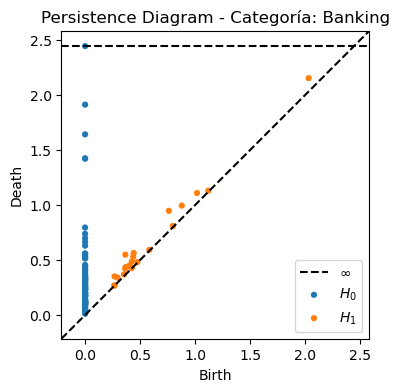

Procesando categoría: Tech
Ejemplo ventana: [-0.00017384  0.00463408  0.01132113 -0.00372116 -0.00011472 -0.00022975
  0.0056643   0.01027345 -0.00509509  0.01638109  0.00089266 -0.00447212
 -0.00821492  0.00022587 -0.01605699 -0.01801204  0.00233518 -0.02091612
 -0.00591151  0.00275084  0.00208824 -0.04435907 -0.02530208  0.04094214
 -0.02163958 -0.02790217  0.01215682  0.03948903  0.00996794  0.01826926
  0.03302729 -0.00324279 -0.00336915 -0.00454931  0.00832432  0.01724198
  0.01957896 -0.00324583 -0.00151491 -0.0176711   0.00689026  0.00345578
 -0.00084874 -0.00932617  0.01085368  0.01703502  0.00962099 -0.00967682
 -0.00853784  0.00117632 -0.00353284 -0.01539706 -0.00034213 -0.02291547
 -0.01423061 -0.02342888  0.04637965 -0.02597567 -0.01111048  0.00777825
 -0.00657748  0.01020686  0.0189414   0.00691064 -0.02591171  0.00986933
  0.01864308 -0.00468641  0.00981037  0.00338233  0.00621917  0.01367003
 -0.0022467  -0.02874947 -0.04183519 -0.00290066 -0.01401696  0.00434782
  0.003

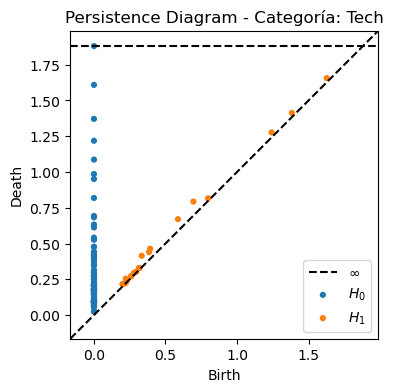

Procesando categoría: Energy
Ejemplo ventana: [ 0.01945002  0.00138298 -0.00080655  0.00448535 -0.00425488 -0.00798387
  0.00982612  0.00676395 -0.00630384  0.01177353 -0.00649846 -0.00320791
  0.01254327  0.00056649  0.00260126 -0.00180886  0.00710377 -0.01118567
 -0.01407465  0.00597413  0.02007248 -0.05231612 -0.05858607 -0.01733479
 -0.01816015 -0.01137167  0.00635436  0.00840975 -0.00157133  0.00209477
 -0.00327507  0.00432085 -0.01037507 -0.01141797  0.01286922  0.02177553
  0.01675517 -0.01714232 -0.02297153 -0.00715548  0.00464399  0.00948444
 -0.00118069 -0.02552601 -0.00188749  0.00591899  0.00907885 -0.0094815
 -0.01255645  0.01107943  0.00936231 -0.01299675 -0.00216025  0.0140913
 -0.02073558 -0.00833396  0.01511356 -0.00406243 -0.01214945  0.02442141
 -0.01880588  0.02428594 -0.00200164  0.01524306 -0.01524306  0.
  0.02896106  0.00466039 -0.00271618  0.00799691  0.00895267 -0.00267739
  0.01129835  0.00252143 -0.00530261  0.00718935 -0.01545139  0.0145712
  0.01696207 -0.

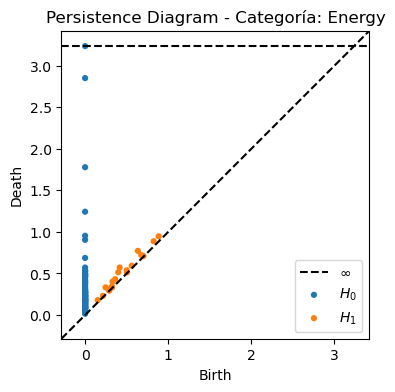

In [29]:
def time_delay_embedding(window, d=3, tau=0):
    W = len(window)
    m = W - (d-1)*tau
    emb = np.vstack([window[i:i+m] for i in range(0, d*tau, tau)]).T
    return emb

def embed(points,d=2,tau=1):
    auxembed=[]
    for i in range(0,len(points)-d+1):
        aux=[points[i+j] for j in range(d)]
        auxembed.append(aux)
    auxembed=np.array(auxembed)
    return auxembed

#Estas dos funciones don diferentes opciones para basicamente lo mismo
# la segunda es una version qu evi en mi clase de topología



# Procesar por categorías
for category, tickers_in_category in categories.items():
    print(f"Procesando categoría: {category}")
    
    # Combinar las ventanas de todos los tickers en esta categoría
    category_windows = []
    for ticker in tickers_in_category:
        category_windows.extend(Xwins[ticker])  # Agregar las ventanas del ticker actual
    
    # Tomar la primera ventana de la categoría para el ejemplo
    w = category_windows[0]
    tau0 = taus[tickers_in_category[0]]  # Usar el tau del primer ticker en la categoría
    print("Ejemplo ventana:", w, "tau0:", tau0)
    
    # Hacer el embedding
    emb = time_delay_embedding(w, d=2, tau=tau0)
    
    #diagrama de persistencia
    dgms = ripser(StandardScaler().fit_transform(emb), maxdim=1)['dgms']
    plt.figure(figsize=(6, 4))  
    plot_diagrams(dgms)
    plt.title(f"Persistence Diagram - Categoría: {category}")
    plt.show()


## Compute tda features

Procesando categoría: Banking


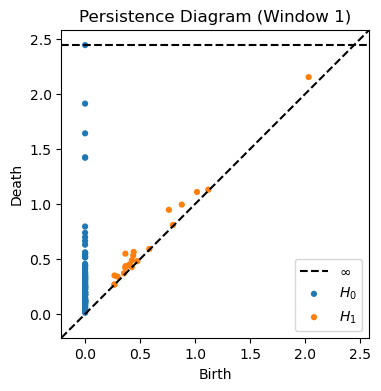

Procesando categoría: Tech


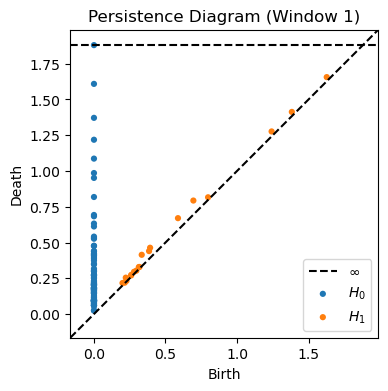

Procesando categoría: Energy


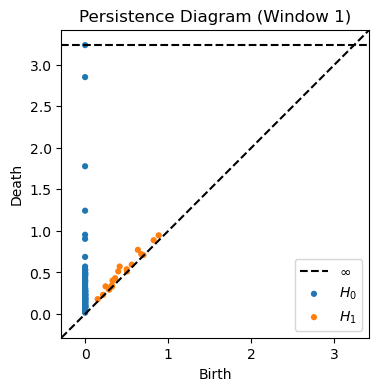

X_imgs shape: (180, 252)


In [30]:
# convertimos ventanas a diagrams y luego a persistence images
def windows_to_diagrams(Xwins_for_category, d=3, tau=1, maxdim=1):
    diagrams = []
    for i,w in enumerate(Xwins_for_category):
        emb = time_delay_embedding(w, d=d, tau=tau) # embed o time_delay_embedding
        emb_s = StandardScaler().fit_transform(emb)
        dgms = ripser(emb_s, maxdim=maxdim)['dgms']
        # Concatenate H0 and H1, and filter out infinite values
        finite_dgms = [dgm[np.isfinite(dgm).all(axis=1)] for dgm in dgms]
        diagrams.append(np.vstack(finite_dgms))
        #graficar algunos de los persistence diagrams 
        if i < 1:  # Graficar solo la primera ventana por categoria, esto cambialo a como quieras, lo dejo así para ahorrar espacio
            fig = plt.figure(figsize=(6, 4))
            ax = fig.add_subplot(111)
            plot_diagrams(dgms, ax=ax, show=False)
            ax.set_title(f"Persistence Diagram (Window {i+1})")
            plt.show()

    return diagrams





# Ejemplo: hacerlo para todos los tickers (usa menos ventanas para demo rápido)
all_diagrams = []
labels = []
'''for t in tickers:
    # tomar sólo primeras N windows si hay muchas
    nmax = 30
    diags = windows_to_diagrams(Xwins[t][:nmax], d=2, tau=taus[t], maxdim=1)
    all_diagrams.extend(diags)
    labels.extend([t]*len(diags))
'''

for category, tickers_in_category in categories.items():
    print(f"Procesando categoría: {category}")
    
    # Combinar las ventanas de todos los tickers en esta categoría
    category_windows = []
    for ticker in tickers_in_category:
        category_windows.extend(Xwins[ticker])  # Agregar las ventanas del ticker actual
    
    # Tomar sólo las primeras N ventanas si hay muchas
    nmax = 30
    category_windows = category_windows[:]
    
    # Calcular diagramas de persistencia para la categoría
    tau0 = taus[tickers_in_category[0]]  # Usar el tau del primer ticker en la categoría
    diags = windows_to_diagrams(category_windows, d=2, tau=tau0, maxdim=1)
    all_diagrams.extend(diags)
    labels.extend([category] * len(diags))  # Usar la categoría como etiqueta



# PersistenceImager (fit con todos)
pim = PersistenceImager(pixel_size=0.2, birth_range=(0,1))
pim.fit(all_diagrams)
X_imgs = np.array([pim.transform(dgm).ravel() for dgm in all_diagrams])
print("X_imgs shape:", X_imgs.shape)


## Train RF 

Accuracy RF-TDA: 0.3055555555555556
              precision    recall  f1-score   support

     Banking       0.31      0.33      0.32        12
      Energy       0.36      0.33      0.35        12
        Tech       0.25      0.25      0.25        12

    accuracy                           0.31        36
   macro avg       0.31      0.31      0.31        36
weighted avg       0.31      0.31      0.31        36



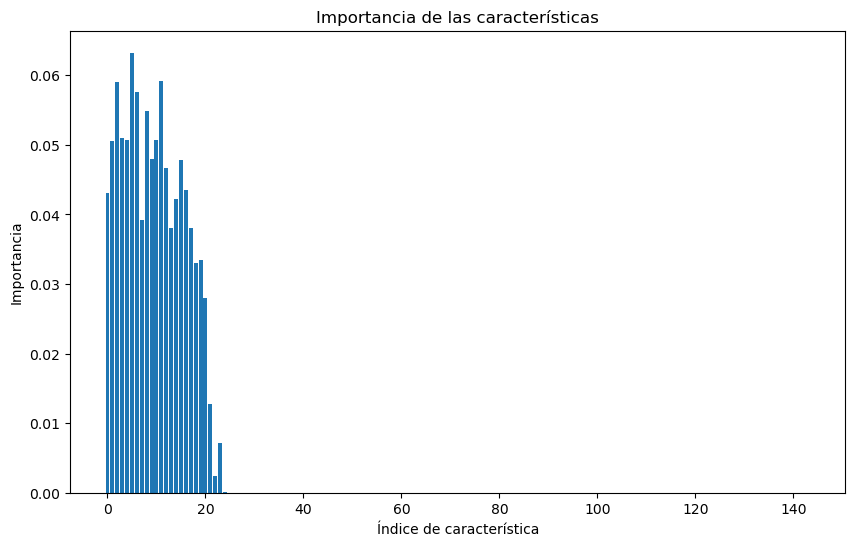

In [31]:
# Codificar las categorías como etiquetas
le = LabelEncoder(); y = le.fit_transform(labels)

X = X_imgs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# opcional: reducción de dimensión si X es muy grande
from sklearn.decomposition import TruncatedSVD
if X.shape[1] > 250:
    svd = TruncatedSVD(n_components=200, random_state=42)
    X_train = svd.fit_transform(X_train)
    X_test = svd.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy RF-TDA:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Mostrar la importancia de las características
importances = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title("Importancia de las características")
plt.xlabel("Índice de característica")
plt.ylabel("Importancia")
plt.show()





[[4 3 5]
 [4 4 4]
 [5 4 3]]


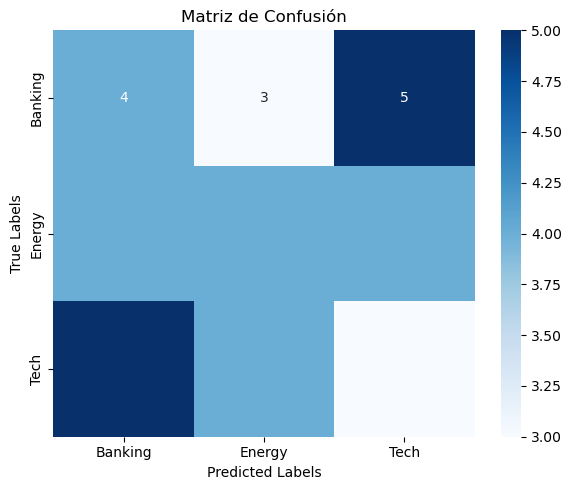

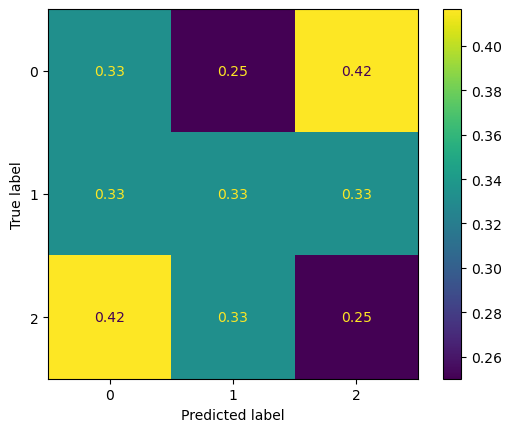

In [32]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')

In [33]:
print("Shape of X_imgs:", X_imgs.shape)

Shape of X_imgs: (180, 252)


## Baseline DWT RF

In [ ]:


def dwt_feats(window, wavelet='db4', level=3):
    
    #Extraer características de una ventana usando la Transformada Wavelet Discreta (DWT).
    coeffs = pywt.wavedec(window, wavelet, level=level)
    feats = np.hstack([np.array([c.mean(), c.std()]) for c in coeffs])
    return feats

#Construir X_dwt alineado a las categorías
X_dwt = []
for category, tickers_in_category in categories.items():
    for ticker in tickers_in_category:
        for w in Xwins[ticker][:30]:  # Tomar las primeras 30 ventanas por ticker
            X_dwt.append(dwt_feats(w))
X_dwt = np.array(X_dwt)

#ajustar dimensiones y entrenar
X_train, X_test, y_train, y_test = train_test_split(X_dwt, y, test_size=0.2, stratify=y, random_state=42)
rf2 = RandomForestClassifier(n_estimators=90, random_state=42, n_jobs=-1)
rf2.fit(X_train, y_train)

#Evaluar
y_pred = rf2.predict(X_test)
print("Accuracy DWT+RF:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy DWT+RF: 0.6666666666666666
              precision    recall  f1-score   support

     Banking       0.78      0.58      0.67        12
      Energy       0.57      0.67      0.62        12
        Tech       0.69      0.75      0.72        12

    accuracy                           0.67        36
   macro avg       0.68      0.67      0.67        36
weighted avg       0.68      0.67      0.67        36



[[7 3 2]
 [1 7 4]
 [1 3 8]]


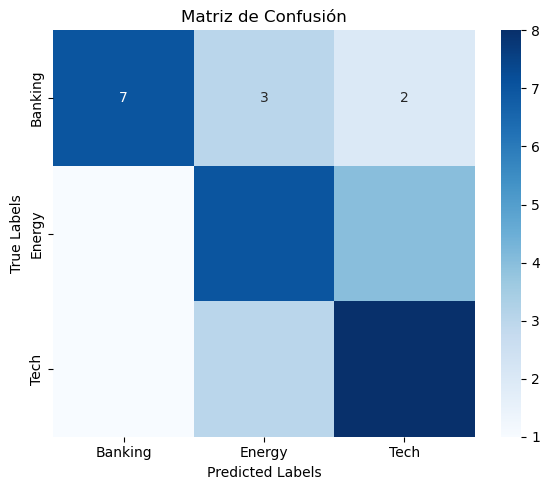

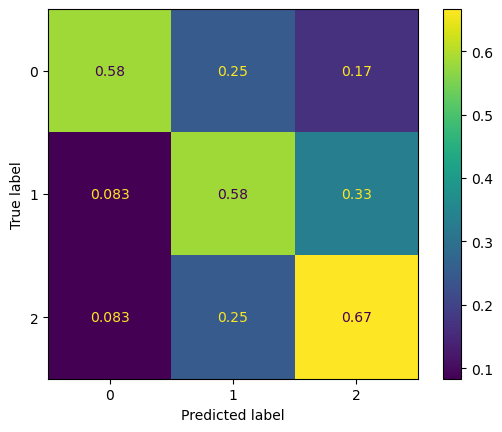

In [35]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')

## Visualizaciones

c:\Users\alfmi\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


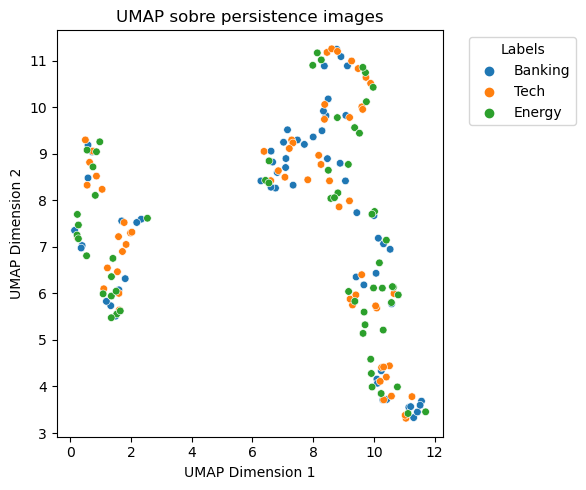

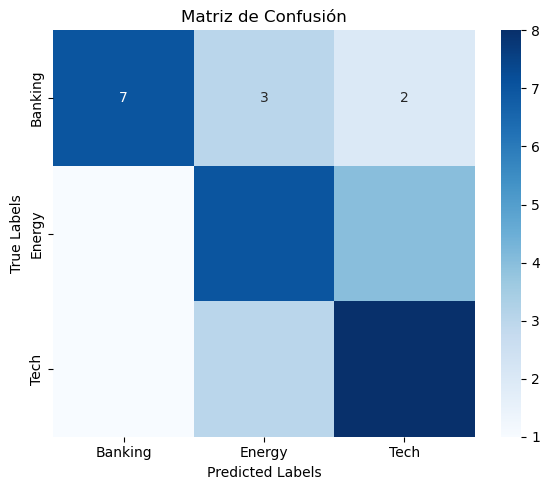

In [36]:
# UMAP de features TDA
um = umap.UMAP(random_state=42)
emb = um.fit_transform(X)

# Gráfico UMAP
plt.figure(figsize=(6, 5))
sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=labels, s=30)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP sobre persistence images")
plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()
